# <center>Centro Universitário Facens<br/></center>
<br/>
<font size="4"><center><b>Disciplina: Processamento de imagens</b></center></font>
  
<font size="3"><center>Prof. Renato M. Silva</center></font>
<br/>
<br/>

## <center>Avaliação Continuada 2 (AC2)</center>

----
### <center>Nome e RA dos componentes do grupo</center>

    
| Nome     |      RA      | 
|:-        |:-------------:|
|Marcelo Zaguette Junior          | 180998               | 
|Michel Micheloti          |181003              | 
|Fernando Dias Motta          |              | 
|          |              | 
    

----
### Instruções
**1**. Siga boas práticas de programação:
- dar nomes intuitivos para as variáveis
- dar nomes intuitivos para as funções


**2**. O trabalho pode ser feito em grupos de até 5 pessoas, contendo alunos de qualquer uma das turmas da disciplina (CP405TIN1 e CP405TIN2). Apenas uma pessoa do grupo deve submeter o trabalho. Você deve submeter apenas o arquivo .ipynb.

**3**. Cuidado com plágio. Se for detectado plágio entre grupos, a punição será dada para todos os componentes dos grupos envolvidos.

**4**. Antes de submeter o notebook, certifique-se que não há erros de código. Uma forma de se certificar disso é usar a opção **"Reiniciar Kernel e executar todas as células"** do Jupyter ou a opção **"Reiniciar e executar tudo"** do Google Colab. 

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from random import randint
import scipy as sp
import scipy.ndimage as nd

----
## Exercício 1

Implemente uma função que troque os quadrantes em diagonal na imagem e aplique na imagem **figs/lena.jpg**, conforme o primeiro exemplo abaixo. Em seguida, adicione a imagem **figs/facens.png** na imagem resultante, conforme mostrado no segundo exemplo abaixo. Por fim, mostre a imagem na tela.

**Dica**: para remover o fundo da imagem **figs/facens.png**, você pode usar um algoritmo de segmentação, como por exemplo a limiarização. 

<center>
<div style="display:inline-block;">
    <div>
    <div style="padding: 5px; float: left;">
        <img src="imgNotebook/LenaQuadrantes.jpg" width="255" height="128" />
    </div>
    <div style="padding: 5px; float: left;">
        <img src="imgNotebook/LenaFacens.jpg" width="255" height="128" />
    </div>   
</div> 
</center>

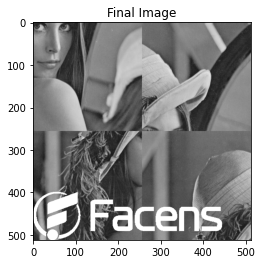

In [2]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(morphed, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)[0]

    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[0: 113, 0: 444]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)

    return dst

initialImage = cv2.imread("figs/lena.jpg")
lenaImageRGB = cv2.cvtColor(initialImage, cv2.COLOR_BGR2RGB)
lenaImage = cv2.cvtColor(lenaImageRGB, cv2.COLOR_BGR2GRAY)
cv2.imwrite('lenaImageGray.png', lenaImage)

crop_img_quad1 = lenaImage[0:256, 256:512]
crop_img_quad2 = lenaImage[0:256, 0:256]
crop_img_quad3 = lenaImage[256:512, 0:256]
crop_img_quad4 = lenaImage[256:512, 256:512]
visVertical1 = np.concatenate((crop_img_quad4,crop_img_quad3), axis=0)
visVertical2 = np.concatenate((crop_img_quad1,crop_img_quad2), axis=0)
reorganizedImage = np.concatenate((visVertical1,visVertical2), axis=1)
cv2.imwrite('reorganizedImageLena.png', reorganizedImage)
reorganizedImage = cv2.imread("reorganizedImageLena.png")

facensLogo = cv2.imread('figs/facens.png')

noBackgroud = remove_background(facensLogo, threshold=250.)

cv2.imwrite("noBackgroundTest.png",noBackgroud)

finalImage = cv2.imread('reorganizedImageLena.png')
coloredFacensLogo = cv2.imread('noBackgroundTest.png')

ret, facensLogo = cv2.threshold(coloredFacensLogo, 0, 255, cv2.THRESH_BINARY)

rows,cols,channels = facensLogo.shape
roi = finalImage[399:rows+399, 0:cols]
facensLogogray = cv2.cvtColor(facensLogo,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(facensLogogray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
finalImage_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

facensLogo_fg = cv2.bitwise_and(facensLogo,facensLogo,mask = mask_inv)
dst = cv2.add(finalImage_bg,facensLogo_fg)
finalImage[399: rows+399, 0:cols ] = dst


black_pixels = np.where(
    (finalImage[:, :, 0] == 0) & 
    (finalImage[:, :, 1] == 0) & 
    (finalImage[:, :, 2] == 0)
)

# set those pixels to white
finalImage[black_pixels] = [255, 255, 255]
plt.imshow(finalImage)
plt.title("Final Image")
plt.show()

----
## Exercício 2

Implemente uma função que consiga fazer a detecção de movimentos em um vídeo. Ela deverá extrair os frames do vídeo e para cada frame, ele deve calcular o histograma da imagem e compará-lo com o último histograma calculado. Quando a diferença entre estes ultrapassar um limiar pré-estabelecido, simule um alarme interrompendo a função e retornando uma mensagem de alerta. Utilize uma função de comparação que julgar conveniente. 

Teste a função no vídeo *videos/cameraEscondida.mp4*.

In [3]:
##### Resolva o exercício aqui


----
## Exercicio 3

Por meio de operações morfológicas e outras técnicas aprendidas na disciplina, destaque o arroz da imagem **figs/arroz.tif**. Você deve salvar a nova imagem com o nome **arroz_destacado.jpg**. Abaixo é mostrado um exemplo do resultado esperado.

<img src="imgNotebook/arroz.png" width="410" height="128" />

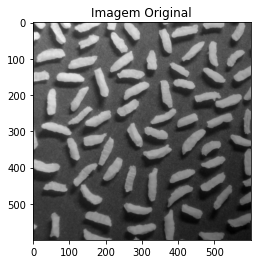

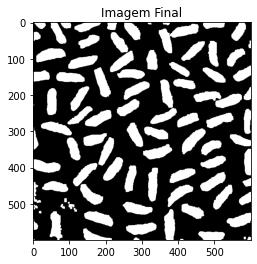

In [4]:
##### Resolva o exercício aqui
img = cv2.imread('figs/arroz.tif', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem Original')
plt.show()

kernel = np.ones((5,5),np.uint8)
thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5) 
opening = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel)

plt.imshow(opening, 'gray')
plt.title('Imagem Final')
plt.show()

----
## Exercicio 4

Remova o ruído das imagens **figs/casa.png** e **figs/placa.tif**. Depois, mostre a imagem restaurada na tela.

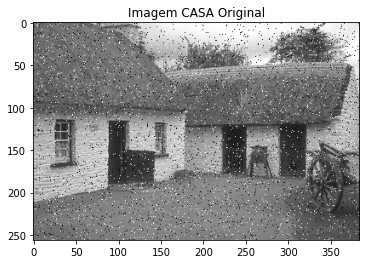

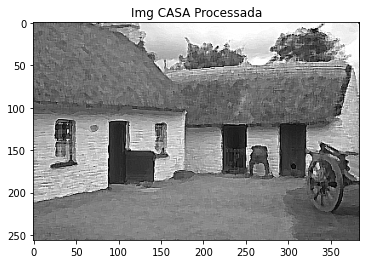

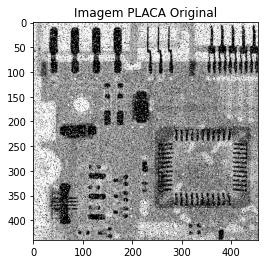

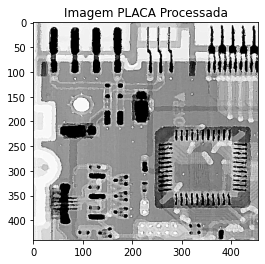

In [5]:
##### Resolva o exercício aqui
img = cv2.imread('figs/casa.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('figs/placa.tif', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem CASA Original')
plt.show()

kernel = np.ones((5,5),np.uint8)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
median = cv2.medianBlur(img,5)
sharpen = cv2.filter2D(median, -1, sharpen_kernel)
plt.imshow(sharpen, 'gray')
plt.title('Img CASA Processada')
plt.show()

plt.imshow(img2, 'gray')
plt.title('Imagem PLACA Original')
plt.show()

median2 = cv2.medianBlur(img2,5)
sharpen2 = cv2.filter2D(median2, -1, sharpen_kernel)
plt.imshow(sharpen2, 'gray')
plt.title('Imagem PLACA Processada')
plt.show()


----
## Exercicio 5

Utilize operações morfológicas nas imagens **figs/manequim.png** e **figs/tabuleiro.jpg** para remover os pontos brancos. Depois, mostre as imagens restauradas na tela.

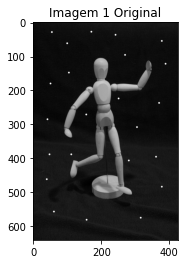

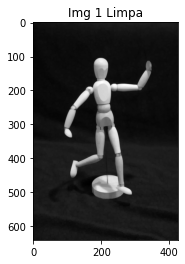

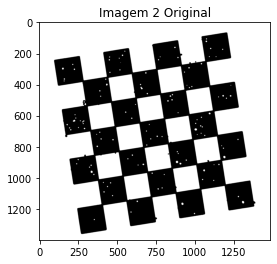

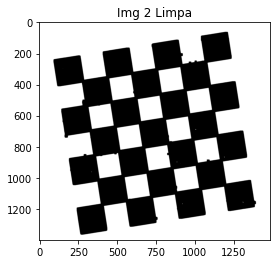

In [6]:
##### Resolva o exercício aqui
kernel = np.ones((5,5),np.uint8)

img = cv2.imread('figs/manequim.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('figs/tabuleiro.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem 1 Original')
plt.show()

imgOpening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
plt.imshow(imgOpening, 'gray')
plt.title('Img 1 Limpa')
plt.show()

plt.imshow(img2, 'gray')
plt.title('Imagem 2 Original')
plt.show()

img2Opening = cv2.morphologyEx(img2, cv2.MORPH_RECT, kernel)
img2Opening = cv2.morphologyEx(img2Opening, cv2.MORPH_RECT, kernel)

plt.imshow(img2Opening, 'gray')
plt.title('Img 2 Limpa')
plt.show()

----
## Exercicio 6

Por meio de operações morfológicas, remova o círculos menores da imagem **figs/circulos.tif**, deixando apenas os círculos maiores. 

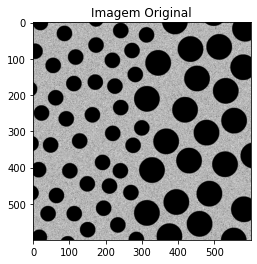

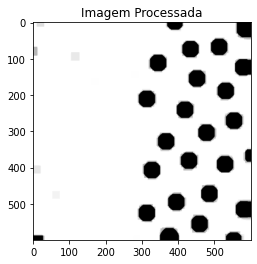

In [7]:
##### Resolva o exercício aqui
img = cv2.imread('figs/circulos.tif', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem Original')
plt.show()

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(img,kernel,iterations = 9)
erosion = cv2.erode(dilation,kernel,iterations = 5)

plt.imshow(erosion, 'gray')
plt.title('Imagem Processada')
plt.show()

----
## Exercicio 7

Aplique um filtro Gaussiano na imagem **figs/lena_noise.png** para diminuir o ruído e mostre na tela. Depois, faça a detecção de bordas da imagem resultante usando as seguintes técnicas: Sobel, Prewitt e Frei-Chen. Mostre na tela os resultado obtido após cada uma das técnicas de detecção de bordas.

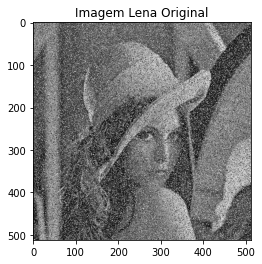

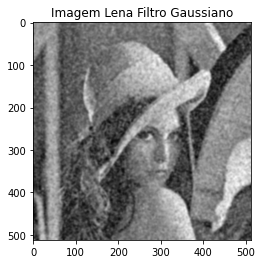

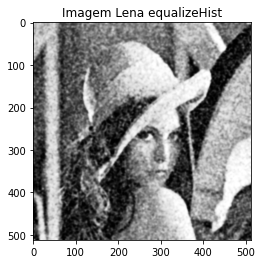

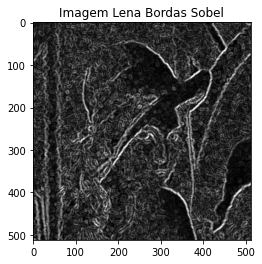

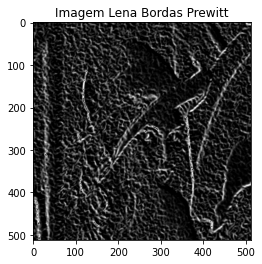

In [8]:
##### Resolva o exercício aqui
img = cv2.imread('figs/lena_noise.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem Lena Original')
plt.show()


blur = cv2.GaussianBlur(img,(11,11),0)

plt.imshow(blur, 'gray')
plt.title('Imagem Lena Filtro Gaussiano')
plt.show()

dst = cv2.equalizeHist(blur)

plt.imshow(dst, 'gray')
plt.title('Imagem Lena equalizeHist')
plt.show()

sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

sobel_xy = np.maximum(sobel_x, sobel_y)

scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_x = cv2.Sobel(dst, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(dst, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.imshow(grad, 'gray')
plt.title('Imagem Lena Bordas Sobel')
plt.show()


kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv2.filter2D(dst, -1, kernelx)
img_prewitty = cv2.filter2D(dst, -1, kernely)

img_prewitt = img_prewittx + img_prewitty

plt.imshow(img_prewitt,'gray')
plt.title("Imagem Lena Bordas Prewitt")
plt.show()


#Frei-Chen


----
## Exercicio 8

Por meio das técnicas aprendidas na disciplina, tente melhorar o **máximo** possível a imagem **figs/lena_pontilhada.png**. 

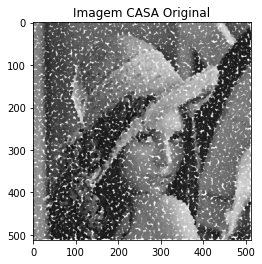

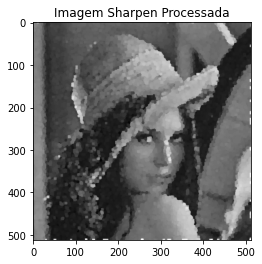

In [9]:
##### Resolva o exercício aqui
img = cv2.imread('figs/lena_pontilhada.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, 'gray')
plt.title('Imagem CASA Original')
plt.show()

kernel = np.ones((5,5),np.uint8)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])


median = cv2.medianBlur(img,1)

rect = cv2.morphologyEx(median, cv2.MORPH_RECT, kernel)
dilate = cv2.dilate(rect,kernel,iterations = 1)

plt.imshow(dilate, 'gray')
plt.title('Imagem Sharpen Processada')
plt.show()



----
## Exercicio 9

Aplique um filtro para borrar as extremidades da imagem **figs/vista.jpg** para que ela fique com o efeito mostrado na imagem abaixo.

<img src="imgNotebook/vista_blur.jpg" width="500" height="128" />

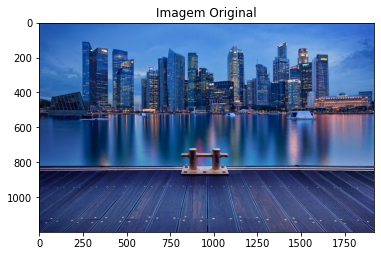

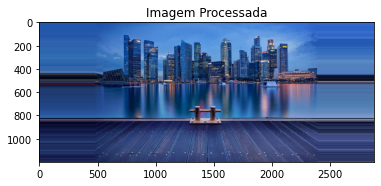

In [10]:
##### Resolva o exercício aqui
img = cv2.imread('figs/vista.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img, 'gray')
plt.title('Imagem Original')
plt.show()

# Initialize arguments for the filter
top = int(0 * img.shape[0])  # shape[0] = rows
bottom = top
left = int(0.25 * img.shape[1])  # shape[1] = cols
right = left

value = [randint(0, 255), randint(0, 255), randint(0, 255)]
#    borderType = cv2.BORDER_CONSTANT
#    borderType = cv2.BORDER_REPLICATE

dst = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_REPLICATE, None, value)

plt.imshow(dst, 'gray')
plt.title('Imagem Processada')
plt.show()

----
## Exercicio 10

As imagens **Degraded_A.jpg** e **Degraded_B.jpg** possuem algum grau de degradação. Melhore a qualidade dessas imagens com as técnicas aprendidas na disciplina e mostre o resultado na tela. O resultado final deve ser o mais próximo possível da imagem original mostrada abaixo. 

<img src="imgNotebook/Desired.jpg" width="250" />

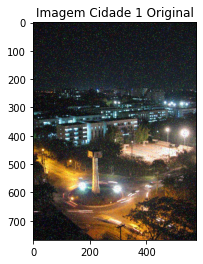

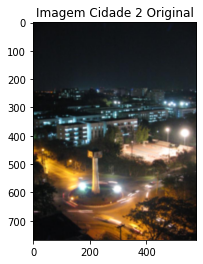

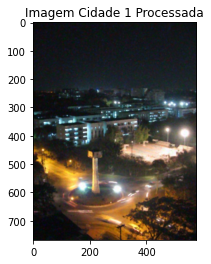

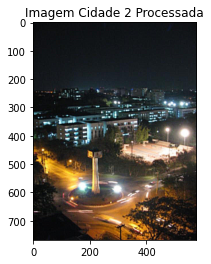

In [11]:
img = cv2.imread('figs/Degraded_A.jpg')
img2 = cv2.imread('figs/Degraded_D.jpg')

median = cv2.medianBlur(img,5)
cv2.imwrite("figs/exe10_img.jpg",median)


sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#median = cv2.medianBlur(img,5)
sharpen = cv2.filter2D(img2, -1, sharpen_kernel)

cv2.imwrite("figs/exe10_img2.jpg",sharpen)

imgFinal1 = cv2.imread('figs/exe10_img.jpg')
imgFinal2 = cv2.imread('figs/exe10_img2.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
imgFinal1 = cv2.cvtColor(imgFinal1, cv2.COLOR_BGR2RGB)
imgFinal2 = cv2.cvtColor(imgFinal2, cv2.COLOR_BGR2RGB)

plt.imshow(img, 'gray')
plt.title('Imagem Cidade 1 Original')
plt.show()

plt.imshow(img2, 'gray')
plt.title('Imagem Cidade 2 Original')
plt.show()

plt.imshow(imgFinal1)
plt.title('Imagem Cidade 1 Processada')
plt.show()

plt.imshow(imgFinal2)
plt.title('Imagem Cidade 2 Processada')
plt.show()

